# Master Strategy (Long-Term + Short-Term) Backtest
This backtest combines both long-term and short-term trading strategies to evaluate their performance over a specified period. The long-term strategy focuses on holding positions for an extended duration, while the short-term strategy involves frequent trades based on market trends. The goal is to assess the overall profitability and risk management of using both strategies in tandem.

### **Step 1: Import Libraries** 

In [26]:
# UDFs and libraries
from py.utils import load_and_filter_data
import glob, os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import bt

### **Step 2: Define Parameters**

#### Date Range

In [27]:
end_date = (datetime.today() - BDay(1)).to_pydatetime()
start_date = end_date - timedelta(days=10*365)
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} ({(end_date - start_date).days/365:.2f} years)")

Date Range: 2015-06-09 to 2025-06-06 (10.00 years)


#### Risk-free rate (T-bill, %)

In [28]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print(f"Risk-Free Rate: {risk_free_rate:.4f}")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424


#### Portfolio Data

In [29]:
# Load portfolio data
output_file = max(glob.glob('portfolios/portfolio-*.xlsx'), key=os.path.getmtime) if glob.glob('portfolios/portfolio-*.xlsx') else f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
print(f"Using: {output_file}")

long_term_portfolio_df = pd.read_excel(output_file, sheet_name='long_term')
short_term_portfolio_df = pd.read_excel(output_file, sheet_name='short_term')
benchmark_long_term_df = pd.read_excel(output_file, sheet_name='benchmark_long_term')
benchmark_short_term_df = pd.read_excel(output_file, sheet_name='benchmark_short_term')
combined_portfolio_df = pd.concat([long_term_portfolio_df, short_term_portfolio_df], ignore_index=True)
tickers = combined_portfolio_df['Ticker'].unique()

print(f"Tickers: {', '.join(tickers)}")
display(combined_portfolio_df)

Using: portfolios/portfolio-2025-06-06.xlsx
Tickers: MMC, AMAT, TMUS, MRK, APO, GRMN, MSFT


,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,Volatility,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score
0,MMC,2025-06-02,"Marsh & McLennan Companies, Inc.",Financial Services,Insurance Brokers,United States,https://www.marshmclennan.com,115130826752,136148770816,491821141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMAT,2025-06-02,"Applied Materials, Inc.",Technology,Semiconductor Equipment & Materials,United States,https://www.appliedmaterials.com,125791559680,125714595840,799392549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TMUS,2025-06-02,"T-Mobile US, Inc.",Communication Services,Telecom Services,United States,https://www.t-mobile.com,275005997056,384693796864,452736028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MRK,2025-06-02,"Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,United States,https://www.merck.com,192947535872,218628636672,2507088934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,APO,2025-06-02,"Apollo Global Management, Inc.",Financial Services,Asset Management,United States,https://www.apollo.com/institutional/homepage,74688552960,94705582080,446479870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,GRMN,2025-06-02,Garmin Ltd.,Technology,Scientific & Technical Instruments,Switzerland,https://www.garmin.com,39080046592,36584062976,174794910,...,0.249987,10.0,190.0,6.0,0.6083,0.0000,0.3333,0.2167,0.4831,0.566
6,MSFT,2025-06-02,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3421643997184,3447046799360,7422063978,...,0.267611,30.0,190.0,41.0,0.5961,0.0488,0.6098,0.1922,0.4831,0.566


#### **Step 3: Import Stock Data | Split Data into Training and Testing Sets**

In [30]:
# Load and split data
# data = load_and_filter_data('data/daily_quotes.csv', tickers, start_date, end_date)
data = pd.read_excel(output_file, sheet_name='daily_quotes', index_col=0, parse_dates=True)
total_rows = len(data)
train_size = int(0.8 * total_rows)
training_set = data.iloc[:train_size]
test_set = data.iloc[train_size:]

print(f"Training: {len(training_set)} rows ({len(training_set)/total_rows:.1%}) | Testing: {len(test_set)} rows ({len(test_set)/total_rows:.1%})")
print(f"Training period: {training_set.index[0]} to {training_set.index[-1]}")
print(f"Testing period: {test_set.index[0]} to {test_set.index[-1]}")

Training: 2009 rows (80.0%) | Testing: 503 rows (20.0%)
Training period: 2015-06-10 00:00:00 to 2023-06-01 00:00:00
Testing period: 2023-06-02 00:00:00 to 2025-06-04 00:00:00


#### **Step 4: Create & Backtest Strategy**

In [31]:
display(long_term_portfolio_df[['Ticker', 'Strategy', 'Weight' ]])
display(short_term_portfolio_df[['Ticker', 'Strategy', 'Short Period', 'Long Period', 'Weight' ]])

,Ticker,Strategy,Weight
0,MMC,Markowitz,0.318087
1,AMAT,Markowitz,0.228911
2,TMUS,Markowitz,0.223672
3,MRK,Markowitz,0.145330
4,APO,Markowitz,0.084000


,Ticker,Strategy,Short Period,Long Period,Weight
0,GRMN,SMA_Cross_Signal,10,190,0.5
1,MSFT,SMA_Cross_Signal,30,190,0.5


#### Assign Asset Weights

In [32]:
# Extract weights and benchmarks
long_term_weights = dict(zip(long_term_portfolio_df['Ticker'], long_term_portfolio_df['Weight']))
short_term_weights = dict(zip(short_term_portfolio_df['Ticker'], short_term_portfolio_df['Weight']))
# Extract benchmark tickers
long_term_benchmarks = benchmark_long_term_df['Benchmark'].tolist()
short_term_benchmarks = benchmark_short_term_df['Benchmark'].tolist()
all_benchmarks = list(set(long_term_benchmarks + short_term_benchmarks))

tickers = list(set(combined_portfolio_df['Ticker'].unique().tolist() + all_benchmarks))

weights_df = combined_portfolio_df[['Ticker', 'Weight']]

weights = dict(zip(weights_df['Ticker'], weights_df['Weight']))
print(weights)

{'MMC': 0.3180873008417999, 'AMAT': 0.2289105824374544, 'TMUS': 0.2236721160100146, 'MRK': 0.1453300807748326, 'APO': 0.08399991993589846, 'GRMN': 0.5, 'MSFT': 0.5}


In [33]:
# Cell: Create Target Weights
strategy_info = combined_portfolio_df[['Ticker', 'Strategy', 'Short Period', 'Long Period', 'Weight']].dropna(subset=['Strategy'])
all_target_weights = pd.DataFrame(0.0, index=data.index, columns=tickers)

# Process SMA/EMA strategies
for strategy_type in ['SMA', 'EMA']:
    strategy_tickers = strategy_info[strategy_info['Strategy'].str.upper().str.contains(strategy_type)]
    if strategy_tickers.empty: continue
    
    for _, row in strategy_tickers.iterrows():
        ticker, short_p, long_p, weight = row['Ticker'], int(row['Short Period']), int(row['Long Period']), row['Weight']
        if ticker in data.columns:
            if strategy_type == 'SMA':
                short_ma, long_ma = data[ticker].rolling(short_p).mean(), data[ticker].rolling(long_p).mean()
            else:
                short_ma, long_ma = data[ticker].ewm(span=short_p).mean(), data[ticker].ewm(span=long_p).mean()
            all_target_weights[ticker] = np.where(short_ma > long_ma, weight, -weight)

# Apply static weights
static_weights = {row['Ticker']: row['Weight'] for _, row in combined_portfolio_df[combined_portfolio_df['Strategy'].isna()].iterrows() if row['Ticker'] in data.columns}
for ticker, weight in static_weights.items():
    all_target_weights[ticker] = weight

print(f"Strategies created - Static: {len(static_weights)}")

# Cell: Create Strategies
long_term_weights = dict(zip(long_term_portfolio_df['Ticker'], long_term_portfolio_df['Weight']))
short_term_weights = dict(zip(short_term_portfolio_df['Ticker'], short_term_portfolio_df['Weight']))

Strategies created - Static: 0


#### Master Strategy

In [34]:
# Master Strategy
master_strategy = bt.Strategy('Master Strategy', 
    [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**{'Long Term Strategy': 0.85, 'Short Term Strategy': 0.15}), bt.algos.Rebalance()],
    children=[
        bt.Strategy('Long Term Strategy', [bt.algos.RunEveryNPeriods(66, offset=66), bt.algos.SelectAll(), bt.algos.WeighSpecified(**long_term_weights), bt.algos.Rebalance()]),
        bt.Strategy('Short Term Strategy', [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**short_term_weights), bt.algos.Rebalance()])
    ])
test1 = bt.Backtest(master_strategy, test_set)

#### Benchmark Strategy

In [35]:
# Create Benchmark Strategies
benchmark_strategies = []

# Long-Term Benchmark Strategy
if long_term_benchmarks:
    # Filter benchmarks that exist in the test data and remove duplicates
    available_long_benchmarks = list(set([ticker for ticker in long_term_benchmarks if ticker in test_set.columns]))
    
    if available_long_benchmarks:
        # Create equal weights for available benchmarks
        long_term_benchmark_weights = {ticker: 1.0/len(available_long_benchmarks) for ticker in available_long_benchmarks}
        
        long_term_benchmark_strategy = bt.Strategy('Long Term Benchmark', [
            bt.algos.RunEveryNPeriods(66, offset=66),  # Same rebalancing frequency as long-term strategy
            bt.algos.SelectAll(),
            bt.algos.WeighSpecified(**long_term_benchmark_weights),
            bt.algos.Rebalance()
        ])
        
        # Select only unique columns for the benchmark data
        long_term_benchmark_data = test_set[available_long_benchmarks].copy()
        benchmark_strategies.append(bt.Backtest(long_term_benchmark_strategy, long_term_benchmark_data))
        print(f"Long Term Benchmark created with tickers: {available_long_benchmarks}")
    else:
        print("No long-term benchmark tickers found in test data")

# Short-Term Benchmark Strategy
if short_term_benchmarks:
    # Filter benchmarks that exist in the test data and remove duplicates
    available_short_benchmarks = list(set([ticker for ticker in short_term_benchmarks if ticker in test_set.columns]))
    
    if available_short_benchmarks:
        # Create equal weights for available benchmarks
        short_term_benchmark_weights = {ticker: 1.0/len(available_short_benchmarks) for ticker in available_short_benchmarks}
        
        short_term_benchmark_strategy = bt.Strategy('Short Term Benchmark', [
            bt.algos.RunWeekly(),  # Same rebalancing frequency as short-term strategy
            bt.algos.SelectAll(),
            bt.algos.WeighSpecified(**short_term_benchmark_weights),
            bt.algos.Rebalance()
        ])
        
        # Select only unique columns for the benchmark data
        short_term_benchmark_data = test_set[available_short_benchmarks].copy()
        benchmark_strategies.append(bt.Backtest(short_term_benchmark_strategy, short_term_benchmark_data))
        print(f"Short Term Benchmark created with tickers: {available_short_benchmarks}")
    else:
        print("No short-term benchmark tickers found in test data")

# Combined Benchmark Strategy (if both benchmarks exist)
if len(benchmark_strategies) == 2:
    # Create a combined benchmark that mirrors the master strategy allocation
    combined_benchmark_strategy = bt.Strategy('Combined Benchmark',
                                            [
                                                bt.algos.RunWeekly(),
                                                bt.algos.SelectAll(),
                                                bt.algos.WeighSpecified(**{
                                                    'Long Term Benchmark': 0.85,
                                                    'Short Term Benchmark': 0.15
                                                }),
                                                bt.algos.Rebalance()
                                            ],
                                            children=[benchmark_strategies[0].strategy, benchmark_strategies[1].strategy])
    
    benchmark_strategies.append(bt.Backtest(combined_benchmark_strategy, test_set))
    print("Combined Benchmark strategy created")

# Create main strategy backtest
test2 = bt.Backtest(combined_benchmark_strategy, test_set)

Long Term Benchmark created with tickers: ['YYY']
Short Term Benchmark created with tickers: ['DSI']
Combined Benchmark strategy created


#### **Step 5: Run Backtest**

In [36]:
res1 = bt.run(test1)
res2 = bt.run(test2)
res = bt.run(test1, test2)
res1.set_riskfree_rate(risk_free_rate)
res2.set_riskfree_rate(risk_free_rate)
res.set_riskfree_rate(risk_free_rate)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20815.40it/s]


#### **Step 6: Visualize Results**

Stat                 Master Strategy    Combined Benchmark
-------------------  -----------------  --------------------
Start                2023-06-01         2023-06-01
End                  2025-06-04         2025-06-04
Risk-free rate       4.24%              4.24%

Total Return         35.20%             24.08%
Daily Sharpe         0.81               0.65
Daily Sortino        1.34               0.96
CAGR                 16.19%             11.33%
Max Drawdown         -14.35%            -14.91%
Calmar Ratio         1.13               0.76

MTD                  0.86%              0.73%
3m                   -1.47%             1.19%
6m                   -4.78%             -1.87%
YTD                  2.23%              2.97%
1Y                   5.80%              7.62%
3Y (ann.)            16.19%             11.33%
5Y (ann.)            -                  -
10Y (ann.)           -                  -
Since Incep. (ann.)  16.19%             11.33%

Daily Sharpe         0.81               0.6

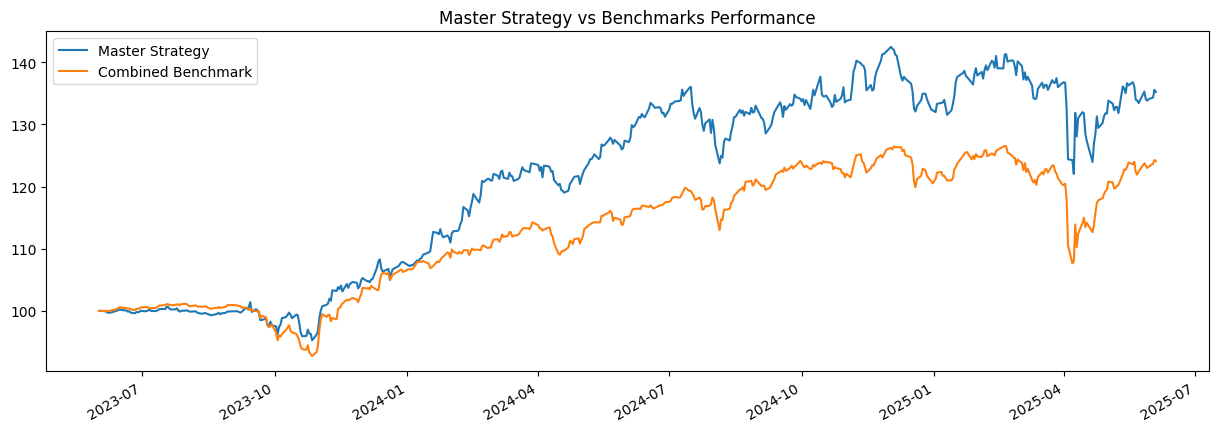

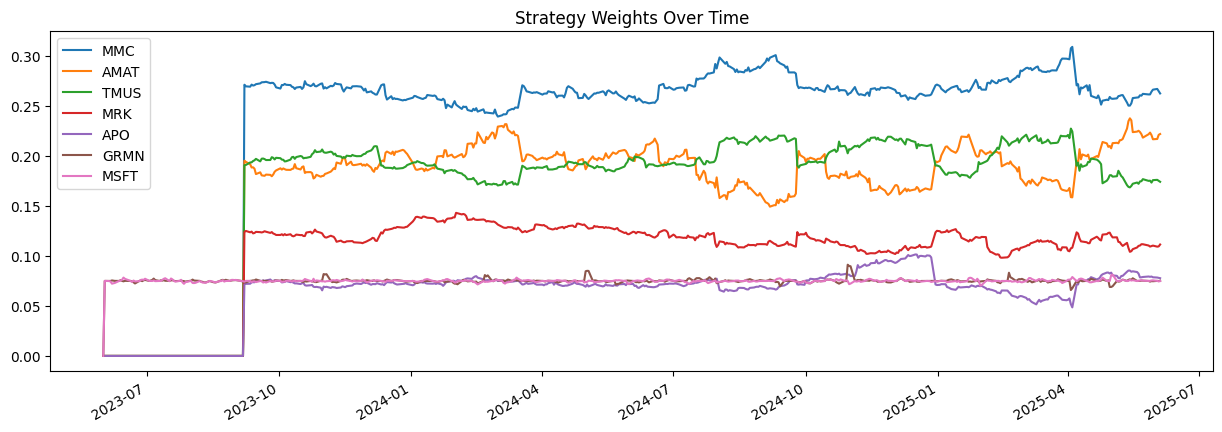

In [37]:
res.display()
res.plot(title='Master Strategy vs Benchmarks Performance')
res.plot_security_weights(title='Strategy Weights Over Time')

#### **Step 7: Transaction Costs Analysis**

100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


Stat                 Master Strategy (No Costs)    Master Strategy (With Costs)    Combined Benchmark
-------------------  ----------------------------  ------------------------------  --------------------
Start                2023-06-01                    2023-06-01                      2023-06-01
End                  2025-06-04                    2025-06-04                      2025-06-04
Risk-free rate       4.24%                         4.24%                           4.24%

Total Return         35.20%                        35.13%                          24.08%
Daily Sharpe         0.81                          0.81                            0.65
Daily Sortino        1.34                          1.34                            0.96
CAGR                 16.19%                        16.16%                          11.33%
Max Drawdown         -14.35%                       -14.32%                         -14.91%
Calmar Ratio         1.13                          1.13              

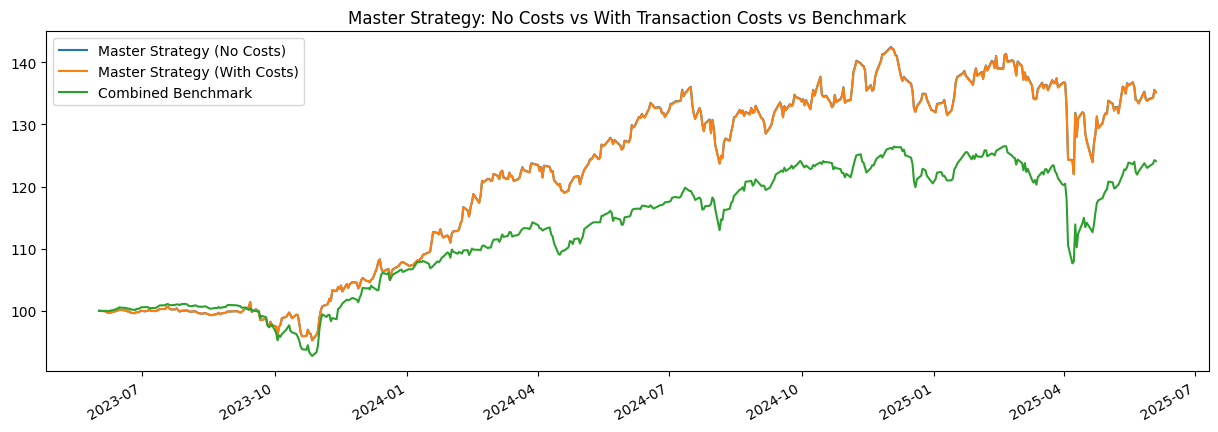

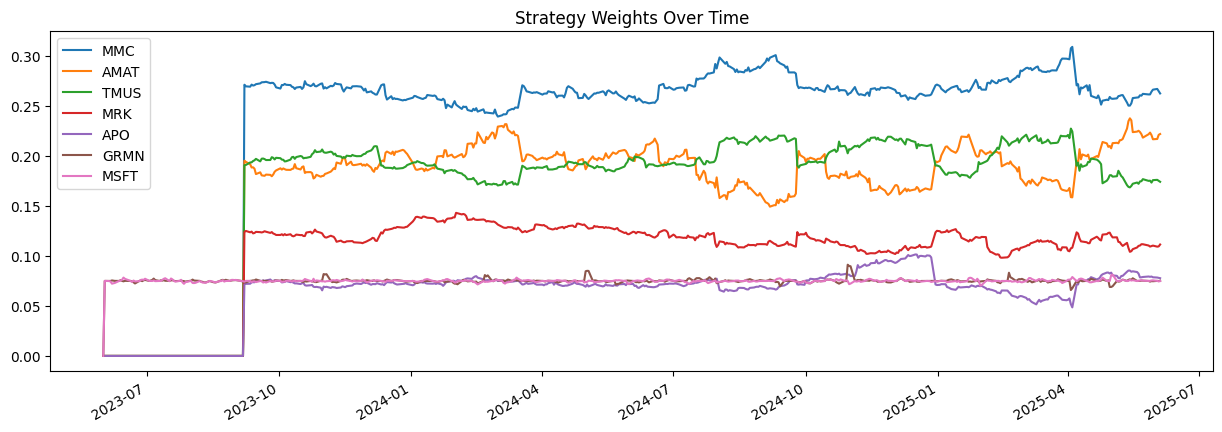

In [38]:
# Cell: Custom Transaction Cost Algorithm
class AdjustWeightsForTransactionCost(bt.Algo):
    def __init__(self, cost):
        super().__init__()
        self.cost = cost

    def __call__(self, target):
        if 'weights' not in target.temp:
            return True

        new_weights = pd.Series(target.temp['weights'])

        try:
            prev_weights = target.get_data('weights_prev')
        except KeyError:
            prev_weights = pd.Series(0, index=new_weights.index)

        # Compute turnover and reduce all weights to simulate cost
        turnover = (new_weights - prev_weights).abs().sum()
        cost_penalty = turnover * self.cost

        # Scale down weights to simulate loss due to cost
        adjusted_weights = new_weights * (1 - cost_penalty)

        # Save back adjusted weights
        target.temp['weights'] = adjusted_weights
        target.temp['weights_prev'] = adjusted_weights.copy()
        return True

# Define transaction cost (e.g., 0.1% = 0.001)
transaction_cost = 0.001

# Cell: Master Strategy with Transaction Costs
# Strategy without costs (original)
master_strategy_no_costs = bt.Strategy('Master Strategy (No Costs)', 
    [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**{'Long Term Strategy': 0.85, 'Short Term Strategy': 0.15}), bt.algos.Rebalance()],
    children=[
        bt.Strategy('Long Term Strategy', [bt.algos.RunEveryNPeriods(66, offset=66), bt.algos.SelectAll(), bt.algos.WeighSpecified(**long_term_weights), bt.algos.Rebalance()]),
        bt.Strategy('Short Term Strategy', [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**short_term_weights), bt.algos.Rebalance()])
    ])

# Strategy with transaction costs
master_strategy_with_costs = bt.Strategy('Master Strategy (With Costs)',
    [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**{'Long Term Strategy': 0.85, 'Short Term Strategy': 0.15}), AdjustWeightsForTransactionCost(transaction_cost), bt.algos.Rebalance()],
    children=[
        bt.Strategy('Long Term Strategy', [bt.algos.RunEveryNPeriods(66, offset=66), bt.algos.SelectAll(), bt.algos.WeighSpecified(**long_term_weights), AdjustWeightsForTransactionCost(transaction_cost), bt.algos.Rebalance()]),
        bt.Strategy('Short Term Strategy', [bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighSpecified(**short_term_weights), AdjustWeightsForTransactionCost(transaction_cost), bt.algos.Rebalance()])
    ])

# Cell: Run Backtests with Transaction Cost Comparison
test1_no_costs = bt.Backtest(master_strategy_no_costs, test_set)
test1_with_costs = bt.Backtest(master_strategy_with_costs, test_set)
test2 = bt.Backtest(combined_benchmark_strategy, test_set)

# Run all strategies
res = bt.run(test1_no_costs, test1_with_costs, test2)
res.set_riskfree_rate(risk_free_rate)

# Cell: Display Results with Transaction Cost Impact
res.display()
res.plot(title='Master Strategy: No Costs vs With Transaction Costs vs Benchmark')
res.plot_security_weights(title='Strategy Weights Over Time')

# Calculate transaction cost impact using total return
no_cost_total_return = res.backtests['Master Strategy (No Costs)'].stats.total_return
with_cost_total_return = res.backtests['Master Strategy (With Costs)'].stats.total_return
return_impact = (no_cost_total_return - with_cost_total_return) * 100

print(f"\n--- Transaction Cost Analysis ---")
print(f"Transaction Cost Rate: {transaction_cost:.3%}")
print(f"Total Return (No Costs): {no_cost_total_return:.2%}")
print(f"Total Return (With Costs): {with_cost_total_return:.2%}")
print(f"Return Impact: -{return_impact:.2f} percentage points")